In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cvxopt
from cvxopt import matrix, solvers
# Math
import numpy as np
from numpy import linalg #import linear algebra
#Scikit
import math
# Copyright 2021 Google Inc. All Rights Reserved.
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at

   # http://www.apache.org/licenses/LICENSE-2.0

#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.
#==============================================================================
#

class Data(object):
    #Dataset1: Generating linearly seperable dataset
    def generate_linearlydataset_linear(self,seed=1):
        np.random.seed(seed)
        mean1 = np.array([0,3])
        mean2 = np.array([3,0])
        return mean1, mean2
    
    def generate_helperdataset(self,mean1, cov, mean2):
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def generate_linearly_separable_data(self,seed=1):
        mean1, mean2 = self.generate_linearlydataset_linear()
        cov = np.array([[0.4, 0.7], [0.7, 0.4]])
        return self.generate_helperdataset(mean1,cov,mean2)

    def gen_non_lin_separable_data(self,seed=1):
        np.random.seed(seed)
        mean1 = [-3, 5]
        mean2 = [5, -3]
        mean3 = [5, -7]
        mean4 = [-7, 5]
        cov = [[1.0, 0.7], [0.7, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_lin_separable_overlap_data(self,seed=1):
        np.random.seed(seed)
        mean1 = np.array([-1, 4])
        mean2 = np.array([4, -1])
        cov = np.array([[4.5, 1.7], [1.7, 4.5]])
        return self.generate_helperdataset(mean1,cov,mean2)

    def split_data(X1, y1, X2, y2,percent):
        dataset_size = len(X1)
        threshold = int(dataset_size*percent);

        # Training data: binary classifier X1, X2
        X1_train = X1[:threshold]
        y1_train = y1[:threshold]
        X2_train = X2[:threshold]
        y2_train = y2[:threshold]

        #stack datasets
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))

        # Test data:
        X1_test = X1[threshold:]
        y1_test = y1[threshold:]
        X2_test = X2[threshold:]
        y2_test = y2[threshold:]

        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))

        return X_train, y_train, X_test, y_test


In [4]:
class Plotting(object):
    def set_legend(self):
      legendElements = [
            Line2D([0], [0], linestyle='none',marker='o', color='red',markerfacecolor='red', markersize=9),
            Line2D([0], [0], linestyle='none',marker='o', color='green', markerfacecolor='green', markersize=9),
            Line2D([0], [0], linestyle='-', marker='.', color='black', markerfacecolor='black',markersize=0),
            Line2D([0], [0], linestyle='--', marker='.', color='blue', markerfacecolor='black', markersize=0),
            Line2D([0], [0], linestyle='none', marker='.', color='black', markerfacecolor='black', markersize=9)
      ]
      return legendElements

    def plot_margin(self,X1, X2, objFit):
        fig = plt.figure()  # create a figure object
        ax = fig.add_subplot(1, 1, 1)
        # Format plot area:
        ax = plt.gca()
        ax = plt.axes(facecolor='#FFFD03')  # background color.
        # Axis limits.
        x1_min, x1_max = X1.min(), X1.max()
        x2_min, x2_max = X2.min(), X2.max()
        ax.set(xlim=(x1_min, x1_max), ylim=(x2_min, x2_max))
        # Labels
        plt.xlabel('$x_1$', fontsize=9)
        plt.ylabel('$x_2$', fontsize=9)
        legendElements = self.set_legend()
        
        myLegend = plt.legend(legendElements,   ['Negative', 'Positive','Decision Boundary','Margin','Support Vectors'],fontsize="7",loc='lower center', bbox_to_anchor=(0.7, 0.98))
        # plot points
        plt.plot(X1[:, 0], X1[:, 1], marker='o',markersize=5, color='red',linestyle='none')
        plt.plot(X2[:, 0], X2[:, 1], marker='o',markersize=4, color='green',linestyle='none')
        plt.scatter(objFit.sv[:, 0], objFit.sv[:, 1], s=60, color="blue")   # The points designating the support vectors.
        
        if  objFit.kernel  == 'polynomial' or objFit.kernel  == 'gaussian':
            # Non-linear margin line needs to be generated. Will use a contour plot.
            _X1, _X2 = np.meshgrid(np.linspace(x1_min, x1_max, 50), np.linspace(x1_min, x1_max, 50))
            X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(_X1), np.ravel(_X2))])

            if objFit.kernel == 'polynomial' or objFit.kernel == 'gaussian':
                Z = objFit.helper(X).reshape(_X1.shape)
            else:
                print("unknown fit_type")
                return

            plt.contour(_X1, _X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
            plt.contour(_X1, _X2, Z + 1, [0.0], colors='grey', linestyles='--', linewidths=1, origin='lower')
            plt.contour(_X1, _X2, Z - 1, [0.0], colors='grey', linestyles='--', linewidths=1, origin='lower')
        else:
            # Linear margin line needs to be generated.
            w = objFit.w
            c = objFit.b
            _y1 = (-w[0] * x1_min - c ) / w[1]
            _y2 = (-w[0] * x1_max - c ) / w[1]
            plt.plot([x1_min, x1_max], [_y1, _y2], "k")

            #upper margin
            _y3 = (-w[0] * x1_min - c + 1) / w[1]
            _y4 = (-w[0] * x1_max - c  + 1) / w[1]
            plt.plot([x1_min, x1_max], [_y3, _y4], "k--")

            #lower_argin
            _y5 = (-w[0] * x1_min - c - 1 ) / w[1]
            _y6 = (-w[0] * x1_max - c - 1 ) / w[1]
            plt.plot([x1_min, x1_max], [_y5, _y6], "k--")

        plt.show(block=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: covariance is not positive-semidefinite.


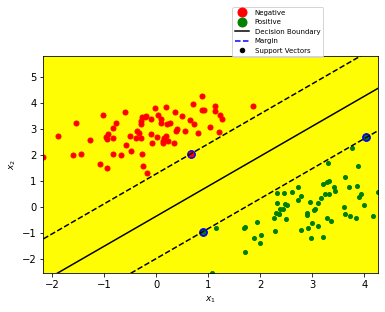

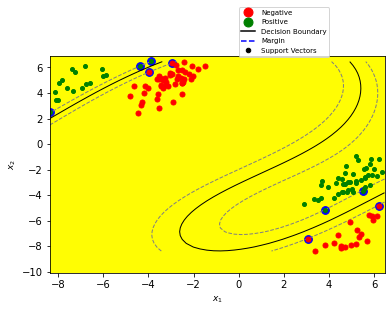

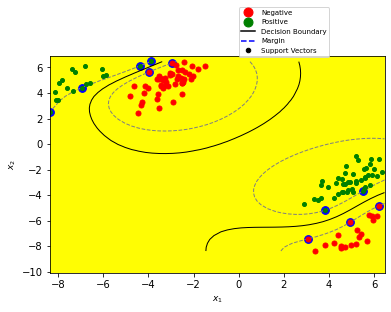

In [7]:
def predict(X,Y,alpha,b,x,sigma):
  result=0.0
  for i in range(X.shape[0]):
    norm= np.linalg.norm(np.subtract(X[i,:] , x))
    res= math.exp(-(norm**2)/(2*(sigma**2)))
    result+=(alpha[i]*Y[i]*res)
  result+=b
  return(result)
class SVM(object):
    '''
        parameters:::
        C:  is a regularization parameter for SVMs.
        gamma:  tries to exactly fit the training data set 
        Degree: of the polynomial kernel function (‘poly’). Ignored by all other kernels
    '''
    def __init__(self, kernel='linear', C=1.0, gamma=1.0, degree = 3):
        self.C = float(C)
        self.gamma = float(gamma)
        self.degree = int(degree)
        self.kernel = str(kernel)
        self.iterations = 50
        self.bias = 0
      
    def linear_kernel(self, x1, x2):
      '''
        Linear Kernel is used when the data is Linearly separable, that is, 
        it can be separated using a single Line.
        For linear kernel the equation for prediction for a new input 
        using the dot product between the input (x) and each support vector(xi) 
        is calculated as follows:
        f(x) = B(0) + sum(ai * (x,xi))
        params:
        x1: input vector
        x2: support vectors
      '''
      return np.dot(x1, x2)

    def polynomial_kernel(self, x, y,C=1, d=3):
        # Inputs:
        #   x   : input var
        #   y   : support vectors
        #   c   : param svm
        #   d   : degree of polynomial.
        #   K(x,xi) = C + sum(x * xi)^d
        return (np.dot(x, y) + C) ** d

    def build_Kernelmatrix(self,X, n_samples):
     '''
        param: input-samples
     '''
     K = np.zeros((n_samples, n_samples))


    def build_Kernelmatrix(self, X, n_samples): #Gram matrix
     K = np.zeros((n_samples, n_samples))
     for i in range(n_samples):
        for j in range(n_samples):
          if self.kernel == 'linear':
            K[i, j] = self.linear_kernel(X[i], X[j])
          if self.kernel=='gaussian':
            K[i, j] = self.gaussian_kernel(X[i], X[j], self.gamma)  
            self.C = None  
          if self.kernel == 'polynomial':
            K[i, j] = self.polynomial_kernel(X[i], X[j], self.C, self.degree)
     return K

    def gaussian_kernel(self, x, y, gamma=0.5):
        # Inputs:
        #   x   : input var
        #   y   : support vectors
        #   gamma   : param
        # K(x,xi) = exp(-gamma * sum((x — xi²)).
        return np.exp(-gamma*linalg.norm(x - y) ** 2 )

    def fit(self, X, y):
        '''
          param:
            X: input smaples
            y: num features
          Let's train our model,
            [Step1] Get num_samples and num_features
            [Step2] Precompute Kernel Matrix since our dataset is small
        '''
        #[step1]:
        n_samples, n_features = X.shape #get datasize_shape
        #[Step2]:
        K = self.build_Kernelmatrix(X, n_samples)
        #Hypothesis: sign(sum^S a * y * kernel + b)
        n = np.outer(y,y)
        P = matrix(n * K)
        q = matrix(-np.ones((n_samples, 1)))
        G = matrix(np.diag(np.ones(n_samples) * -1))
        h = matrix(np.zeros(n_samples))
        b = matrix(np.zeros(1))
        A = matrix(y.reshape(1, -1))
        solvers.options['show_progress'] = False
        # Solve Quadratic Programming problem:
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
      

        alphas = np.ravel(solution['x'])       
        # Support vectors have non zero lagrange multipliers
        sv = alphas > 1e-4
        ind = np.arange(len(alphas))[sv]
        self.alphas = alphas[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        # Bias (For linear it is the intercept):
        
        self.b = 0
        for n in range(len(self.alphas)):
            # For all support vectors:
            self.b += self.sv_y[n]
            self.b -= np.sum(self.alphas * self.sv_y * K[ind[n], sv])
        self.b = self.b / len(self.alphas)

        # Weight vector
        if self.kernel == 'linear':
            self.w = np.zeros(n_features)
            for n in range(len(self.alphas)):
                self.w += self.alphas[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
        
    def helper(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.alphas, self.sv_y, self.sv):
                    # a : Lagrange multipliers, sv : support vectors.
                    # Hypothesis: sign(sum^S a * y * kernel + b)
                    if self.kernel == 'linear':
                        s += a * sv_y * self.linear_kernel(X[i], sv)
                    if self.kernel=='gaussian':
                        s += a * sv_y * self.gaussian_kernel(X[i], sv, self.gamma)   # Kernel trick.
                        self.C = None   
                    if self.kernel == 'polynomial':
                        s += a * sv_y * self.polynomial_kernel(X[i], sv, self.C, self.degree)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        #Sign values shows the class value of the training sample
        return np.sign(self.helper(X))


def svm(kernel='linear', C=0, gamma=0.1, degree=3, dataset='linearly_separable',split_data = 0.7):

    #Create dataset object
    Data_obj = Data();                                                   
    Plot_obj = Plotting();                                                   # Plotting object.

    # Generate Data:
    if kernel == 'linear':
        if dataset == 'linearly_separable':
            X1, y1, X2, y2 = Data_obj.generate_linearly_separable_data(seed=1)
        else:
            X1, y1, X2, y2 = Data_obj.gen_lin_separable_overlap_data(seed=1)  # Generate the examples.
    
    elif kernel=='polynomial' or kernel=='gaussian':
        X1, y1, X2, y2 = Data_obj.gen_non_lin_separable_data(seed=1)
 
    #Create SVM object
    objFit = SVM(kernel=kernel, C=C, gamma=gamma, degree=degree)  
    #Split dataset into training and testing samples                                           
    X_train, y_train, X_test, y_test = Data.split_data(X1, y1, X2, y2,split_data)   
    #Fit model
    objFit.fit(X_train, y_train)                                            
   # y_predict = objFit.predict(X_test)                                     
    Plot_obj.plot_margin(X_train[y_train == 1], X_train[y_train == -1], objFit); 


if __name__ == "__main__":
    svm(kernel='linear',C=100)
    svm('polynomial',C=1, degree=3)
    svm('gaussian', gamma = 0.1)

